In [1]:
import torch
print(torch.__version__)
if torch.__version__.split('+')[0] == '1.8.1':
  version = '1.8.0'
else:
  version = torch.__version__.split('+')[0]
print(version)

1.8.1+cu101
1.8.0


In [2]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-{version}+cu101.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-{version}+cu101.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-{version}+cu101.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{version}+cu101.html
!pip install torch-geometric

Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html
Looking in links: https://pytorch-geometric.com/whl/torch-1.8.0+cu101.html


In [3]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import degree
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd 
import copy
import matplotlib.pyplot as plt

# Read Data

In [4]:
def data_generator(folder = 'dataset1'):
  
  train_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/train.csv')
  test_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/test.csv')
  content_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/content.csv', delimiter='\t', header= None, index_col=[0])

  self_train_df = train_df[train_df['to']==train_df['from']]
  print(len(self_train_df))
  train_df = train_df[train_df['to']!=train_df['from']]

  self_test_df = test_df[test_df['to']==test_df['from']]
  original_test_df = copy.deepcopy(test_df)
  test_df = test_df[test_df['to']!=test_df['from']]

  pos_train_df = train_df[train_df['label']== 1]
  neg_train_df = train_df[train_df['label']== 0]
  print(f'pos len: {len(pos_train_df)}, neg len: {len(neg_train_df)}')
  train_pos_edge_index= torch.tensor(pos_train_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)
  train_neg_edge_index= torch.tensor(neg_train_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)
  # print(train_pos_edge_index.shape)
  # print(train_neg_edge_index.shape)
  x_feature = content_df.sort_index(ascending=True).to_numpy()
  print(x_feature.shape)

  data = Data(x= x_feature, edge_index=train_pos_edge_index)
  data.num_nodes = x_feature.shape[0]
  print(data.num_nodes)

  test_edge_index = torch.tensor(test_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)

  data.train_pos_edge_index = train_pos_edge_index
  ata.train_neg_edge_index = train_neg_edge_index
  data.test_edge_index = test_edge_index

  return data


In [5]:
import math
import random
import os.path as osp
from itertools import chain
import csv
random.seed(42)
torch.manual_seed(42)

import numpy as np
from sklearn.metrics import roc_auc_score
from scipy.sparse.csgraph import shortest_path
import torch
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss
from torch.nn import ModuleList, Linear, Conv1d, MaxPool1d

from torch_geometric.nn import GCNConv, global_sort_pool
from torch_geometric.data import Data, InMemoryDataset, DataLoader
from torch_geometric.utils import negative_sampling, add_self_loops, train_test_split_edges, k_hop_subgraph, to_scipy_sparse_matrix

# Dataset
* train_test_split_edges: Splits the edges of a torch_geometric.data.Data object into positive and negative train/val/test edges, and adds attributes of train_pos_edge_index, train_neg_adj_mask, val_pos_edge_index, val_neg_edge_index, test_pos_edge_index, and test_neg_edge_index to data.
* negative sampling: Samples random negative edges of a graph given by edge_index.
* k_hop_subgraph: Computes the 𝑘-hop subgraph of edge_index around node node_idx. It returns (1) the nodes involved in the subgraph, (2) the filtered edge_index connectivity, (3) the mapping from node indices in node_idx to their new location, and (4) the edge mask indicating which edges were preserved.

## Train Test Dataset

In [6]:
# Paper: Link Prediction Based on Graph Neural Networks (NeurIPS 2018)

class SEALDataset(InMemoryDataset):
  def __init__(self, data, num_hops, split='train', device= 'cpu', attr= False):
    self.data = data
    self.num_hops = num_hops
    self.device= device
    self.split= split
    self.test_dataset = None 
    self.attr = attr
    super(SEALDataset, self).__init__('../')
    index = ['train', 'test'].index(split)
    self.data, self.slices = torch.load(self.processed_paths[index])

  @property
  def processed_file_names(self):
    return ['SEAL_train_data.pt', 'SEAL_test_data.pt']

  def process(self):
    random.seed(12345)
    torch.manual_seed(12345)
    
    self.__max_z__ = 0

    train_pos_list = self.extract_enclosing_subgraphs(
        self.data.train_pos_edge_index, self.data['edge_index'], 1)
    train_neg_list = self.extract_enclosing_subgraphs(
        self.data.train_neg_edge_index, self.data['edge_index'], 0)
    
    if self.attr:
      for data in chain(train_pos_list, train_neg_list):
        data.x = torch.cat([torch.tensor(data.x).to(self.device), F.one_hot(data.z, self.__max_z__ + 1).to(torch.float).to(self.device)], axis= 1)
    else:
      for data in chain(train_pos_list, train_neg_list):
        data.x = F.one_hot(data.z, self.__max_z__ + 1).to(torch.float).to(self.device)

    torch.save(self.collate(train_pos_list + train_neg_list), self.processed_paths[0])

    return None

  def extract_enclosing_subgraphs(self, link_index, edge_index, y):
    data_list = []
    for src, dst in link_index.t().tolist():
      sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
          [src, dst], self.num_hops, edge_index, relabel_nodes=True)
      src, dst = mapping.tolist() # the mapping from node indices in node_idx to their new location

      # Remove target link from the subgraph.
      mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
      mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
      sub_edge_index = sub_edge_index[:, mask1 & mask2]

      # Calculate node labeling.
      z = self.drnl_node_labeling(sub_edge_index, src, dst, num_nodes=sub_nodes.size(0))

      data = Data(x=self.data.x[sub_nodes], z=z, edge_index=sub_edge_index, y=y)
      data_list.append(data)

    return data_list

  def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
    # Double-radius node labeling (DRNL).
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

    idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
    adj_wo_src = adj[idx, :][:, idx]

    idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
    adj_wo_dst = adj[idx, :][:, idx]

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                              indices=src)
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                              indices=dst - 1)
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    self.__max_z__ = max(int(z.max()), self.__max_z__)

    return z.to(torch.long)

## Test Dataset

In [7]:
class TestDataset():
  def __init__(self, data, num_hops, device= 'cpu', attr= False):
    self.data = data
    self.num_hops = num_hops
    self.device= device
    self.attr= attr

  def process(self):
    random.seed(12345)
    torch.manual_seed(12345)
    
    self.__max_z__ = 0
    
    test_list = self.extract_enclosing_subgraphs(
        self.data.test_edge_index, self.data['edge_index'])
    
    if self.attr:
      for data in test_list:
        data.x = torch.cat([torch.tensor(data.x).to(self.device), F.one_hot(data.z, self.__max_z__ + 1).to(torch.float).to(self.device)], axis= 1)
    else:
      for data in test_list:
        data.x = F.one_hot(data.z, self.__max_z__ + 1).to(torch.float).to(self.device)
    
    return test_list

  def extract_enclosing_subgraphs(self, link_index, edge_index):
    data_list = []
    for src, dst in link_index.t().tolist():
      # print(f'src dst: {src}, {dst}')
      sub_nodes, sub_edge_index, mapping, _ = k_hop_subgraph(
          [src, dst], self.num_hops, edge_index, relabel_nodes=True, num_nodes= self.data.num_nodes)
      src, dst = mapping.tolist() # the mapping from node indices in node_idx to their new location
      # print(f'src dst mapped: {src},{dst}')
      # Remove target link from the subgraph.
      mask1 = (sub_edge_index[0] != src) | (sub_edge_index[1] != dst)
      mask2 = (sub_edge_index[0] != dst) | (sub_edge_index[1] != src)
      sub_edge_index = sub_edge_index[:, mask1 & mask2]

      # Calculate node labeling.
      z = self.drnl_node_labeling(sub_edge_index, src, dst, num_nodes=sub_nodes.size(0))

      data = Data(x=self.data.x[sub_nodes], z=z, edge_index=sub_edge_index)
      data_list.append(data)

    return data_list

  def drnl_node_labeling(self, edge_index, src, dst, num_nodes=None):
    # Double-radius node labeling (DRNL).
    src, dst = (dst, src) if src > dst else (src, dst)
    adj = to_scipy_sparse_matrix(edge_index, num_nodes=num_nodes).tocsr()

    idx = list(range(src)) + list(range(src + 1, adj.shape[0]))
    adj_wo_src = adj[idx, :][:, idx]

    idx = list(range(dst)) + list(range(dst + 1, adj.shape[0]))
    adj_wo_dst = adj[idx, :][:, idx]

    dist2src = shortest_path(adj_wo_dst, directed=False, unweighted=True,
                              indices=src)
    dist2src = np.insert(dist2src, dst, 0, axis=0)
    dist2src = torch.from_numpy(dist2src)

    dist2dst = shortest_path(adj_wo_src, directed=False, unweighted=True,
                              indices=dst - 1)
    dist2dst = np.insert(dist2dst, src, 0, axis=0)
    dist2dst = torch.from_numpy(dist2dst)

    dist = dist2src + dist2dst
    dist_over_2, dist_mod_2 = dist // 2, dist % 2

    z = 1 + torch.min(dist2src, dist2dst)
    z += dist_over_2 * (dist_over_2 + dist_mod_2 - 1)
    z[src] = 1.
    z[dst] = 1.
    z[torch.isnan(z)] = 0.

    self.__max_z__ = max(int(z.max()), self.__max_z__)

    return z.to(torch.long)

# Model

In [52]:
class DGCNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers, GNN=GCNConv, k=0.6):
        super(DGCNN, self).__init__()

        if k < 1:  # Transform percentile to number.
            num_nodes = sorted([data.num_nodes for data in train_dataset])
            k = num_nodes[int(math.ceil(k * len(num_nodes))) - 1]
            k = max(10, k)
        self.k = int(k)

        self.convs = ModuleList()
        self.convs.append(GNN(train_dataset.num_features, hidden_channels))
        for i in range(0, num_layers - 1):
            self.convs.append(GNN(hidden_channels, hidden_channels))
        self.convs.append(GNN(hidden_channels, 1))

        conv1d_channels = [16, 32]
        total_latent_dim = hidden_channels * num_layers + 1
        conv1d_kws = [total_latent_dim, 5]
        self.conv1 = Conv1d(1, conv1d_channels[0], conv1d_kws[0],
                            conv1d_kws[0])
        self.maxpool1d = MaxPool1d(2, 2)
        self.conv2 = Conv1d(conv1d_channels[0], conv1d_channels[1],
                            conv1d_kws[1], 1)
        dense_dim = int((self.k - 2) / 2 + 1)
        dense_dim = (dense_dim - conv1d_kws[1] + 1) * conv1d_channels[1]
        self.lin1 = Linear(dense_dim, 128)
        self.lin2 = Linear(128, 1)

    def forward(self, x, edge_index, batch):
        # print(f'x shape: {x.shape}')
        xs = [x]
        for conv in self.convs:
            xs += [torch.tanh(conv(xs[-1], edge_index))]
        x = torch.cat(xs[1:], dim=-1)

        # Global pooling.
        x = global_sort_pool(x, batch, self.k)
        x = x.unsqueeze(1)  # [num_graphs, 1, k * hidden]
        x = F.relu(self.conv1(x))
        x = self.maxpool1d(x)
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)  # [num_graphs, dense_dim]

        # MLP.
        x = F.relu(self.lin1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

# Train & Test

In [53]:
def train():
  
  model.train()

  y_pred, y_true = [], []
  total_loss = 0
  for data in train_loader:
      data = data.to(device)
      optimizer.zero_grad()
      logits = model(data.x, data.edge_index, data.batch)
      loss = BCEWithLogitsLoss()(logits.view(-1), data.y.to(torch.float))
      loss.backward()
      optimizer.step()
      total_loss += loss.item() * data.num_graphs
      y_pred.append(logits.view(-1).detach().cpu())
      y_true.append(data.y.view(-1).detach().cpu().to(torch.float))

  return total_loss / len(train_dataset), roc_auc_score(torch.cat(y_true), torch.cat(y_pred))


def test(loader):
  global model
  model.eval()

  with torch.no_grad():
    y_pred, y_true = [], []
    for data in loader:
        data = data.to(device)
        logits = model(data.x, data.edge_index, data.batch)
        y_pred.append(logits.view(-1).cpu())
        y_true.append(data.y.view(-1).cpu().to(torch.float))

  return roc_auc_score(torch.cat(y_true), torch.cat(y_pred))

In [54]:
def logits_p(logit):
  return 2.71828**logit / (1 + 2.71828**logit)

# 參數

In [89]:
num_hops= 2
batch_size= 32
hidden_channels= 64
num_layers= 3
lr= 1e-4
num_epoch = 30
attr= True
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [90]:
def main(folder = 'dataset1'):
  
  train_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/train.csv')
  test_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/test.csv')
  content_df = pd.read_csv(f'/content/drive/MyDrive/python_data/社群網路與推薦系統/hw2/{folder}/content.csv', delimiter='\t', header= None, index_col=[0])

  self_train_df = train_df[train_df['to']==train_df['from']]
  print(len(self_train_df))
  train_df = train_df[train_df['to']!=train_df['from']]

  self_test_df = test_df[test_df['to']==test_df['from']]
  original_test_df = copy.deepcopy(test_df)
  test_df = test_df[test_df['to']!=test_df['from']]

  pos_train_df = train_df[train_df['label']== 1]
  neg_train_df = train_df[train_df['label']== 0]
  print(f'pos len: {len(pos_train_df)}, neg len: {len(neg_train_df)}')
  train_pos_edge_index= torch.tensor(pos_train_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)
  train_neg_edge_index= torch.tensor(neg_train_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)
  # print(train_pos_edge_index.shape)
  # print(train_neg_edge_index.shape)
  x_feature = content_df.sort_index(ascending=True).to_numpy()
  print(x_feature.shape)

  data = Data(x= x_feature, edge_index=train_pos_edge_index)
  data.num_nodes = x_feature.shape[0]
  print(data.num_nodes)

  test_edge_index = torch.tensor(test_df[['from', 'to']].to_numpy().transpose(), dtype= torch.long)

  data.train_pos_edge_index = train_pos_edge_index
  data.train_neg_edge_index = train_neg_edge_index
  data.test_edge_index = test_edge_index

  global train_dataset
  global train_loader
  global model
  global optimizer

  train_dataset = SEALDataset(data, num_hops= num_hops, split='train', device= device, attr= attr)
  test_dataset = TestDataset(data, num_hops=num_hops, device= device, attr= attr).process()

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  test_loader = DataLoader(test_dataset, batch_size=1)

  model = DGCNN(hidden_channels=hidden_channels, num_layers=num_layers).to(device)
  optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

  train_auc_list = []
  for epoch in range(1, num_epoch+1):
    loss, train_auc = train()
    train_auc_list.append(train_auc)
    print(f'Epoch: {epoch:02d}, Loss: {loss:.3f}, Train: {train_auc:.3f}')
  
  outputs = []
  model.eval()
  with torch.no_grad():
    for data in test_loader: 
      data = data.to(device)
      logits = model(data.x, data.edge_index, data.batch)
      outputs.append(logits_p(logits.cpu().item()))
  len(outputs) == len(test_df)

  # outputs
  count = 0
  with open(f'{folder}_output.csv', 'w') as f: 
    writer = csv.writer(f)
    writer.writerow(['id', 'prob'])
    for id in original_test_df['id'].values:
      if id in self_test_df['id'].values:
        writer.writerow([id, 1])
      else:
        writer.writerow([id, outputs[count]])
        count += 1

  return model, train_auc_list

# Run

In [91]:
# train_auc_list = []
# for epoch in range(1, epoch+1):
#   loss, train_auc = train()
#   train_auc_list.append(train_auc)
#   print(f'Epoch: {epoch:02d}, Loss: {loss:.3f}, Train: {train_auc:.3f}')

In [92]:
folders = ['dataset1', 'dataset2', 'dataset3']
train_auc_lists= []
for folder in folders:
  model, train_auc_list = main(folder= folder)
  train_auc_lists.append(train_auc_list)

0
pos len: 4324, neg len: 4362
(2708, 1433)
2708
Processing...
Done!
Epoch: 01, Loss: 0.684, Train: 0.600
Epoch: 02, Loss: 0.632, Train: 0.695
Epoch: 03, Loss: 0.582, Train: 0.741
Epoch: 04, Loss: 0.552, Train: 0.766
Epoch: 05, Loss: 0.532, Train: 0.786
Epoch: 06, Loss: 0.524, Train: 0.796
Epoch: 07, Loss: 0.513, Train: 0.806
Epoch: 08, Loss: 0.506, Train: 0.815
Epoch: 09, Loss: 0.503, Train: 0.817
Epoch: 10, Loss: 0.493, Train: 0.827
Epoch: 11, Loss: 0.490, Train: 0.830
Epoch: 12, Loss: 0.483, Train: 0.836
Epoch: 13, Loss: 0.476, Train: 0.843
Epoch: 14, Loss: 0.471, Train: 0.847
Epoch: 15, Loss: 0.465, Train: 0.852
Epoch: 16, Loss: 0.464, Train: 0.854
Epoch: 17, Loss: 0.455, Train: 0.861
Epoch: 18, Loss: 0.447, Train: 0.865
Epoch: 19, Loss: 0.444, Train: 0.868
Epoch: 20, Loss: 0.437, Train: 0.874
Epoch: 21, Loss: 0.431, Train: 0.877
Epoch: 22, Loss: 0.426, Train: 0.882
Epoch: 23, Loss: 0.422, Train: 0.884
Epoch: 24, Loss: 0.417, Train: 0.887
Epoch: 25, Loss: 0.406, Train: 0.893
Epoch:

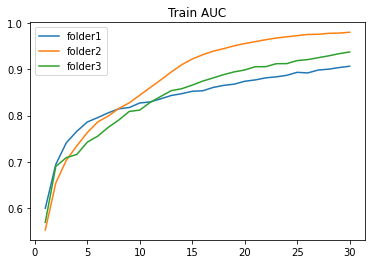

In [93]:
plt.plot(list(range(1, num_epoch+1)), train_auc_lists[0], label= 'folder1')
plt.plot(list(range(1, num_epoch+1)), train_auc_lists[1], label= 'folder2')
plt.plot(list(range(1, num_epoch+1)), train_auc_lists[2], label= 'folder3')
plt.title(f'Train AUC')
plt.legend()
plt.show()

## Output

In [94]:
# outputs = []
# model.eval()
# with torch.no_grad():
#   for data in test_loader: 
#     data = data.to(device)
#     logits = model(data.x, data.edge_index, data.batch)
#     outputs.append(logits_p(logits.cpu().item()))

In [95]:
# len(outputs) == len(test_df)

In [96]:
# # outputs
# count = 0
# with open(f'{folder}_output.csv', 'w') as f: 
#   writer = csv.writer(f)
#   writer.writerow(['id', 'prob'])
#   for id in original_test_df['id'].values:
#     if id in self_test_df['id'].values:
#       writer.writerow([id, 1])
#     else:
#       writer.writerow([id, outputs[count]])
#       count += 1

In [97]:
# import torch_geometric.transforms as T
# from torch_geometric.nn import GCNConv, GAE, VGAE
# from torch_geometric.utils import train_test_split_edges

# data.train_mask = data.val_mask = data.test_mask = data.y = data.batch = None
# new_data = train_test_split_edges(data)


# class GCNEncoder(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(GCNEncoder, self).__init__()
#         self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
#         self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         return self.conv2(x, edge_index)


# class VariationalGCNEncoder(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(VariationalGCNEncoder, self).__init__()
#         self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
#         self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
#         self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index).relu()
#         return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


# class LinearEncoder(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(LinearEncoder, self).__init__()
#         self.conv = GCNConv(in_channels, out_channels, cached=True)

#     def forward(self, x, edge_index):
#         return self.conv(x, edge_index)


# class VariationalLinearEncoder(torch.nn.Module):
#     def __init__(self, in_channels, out_channels):
#         super(VariationalLinearEncoder, self).__init__()
#         self.conv_mu = GCNConv(in_channels, out_channels, cached=True)
#         self.conv_logstd = GCNConv(in_channels, out_channels, cached=True)

#     def forward(self, x, edge_index):
#         return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [98]:
# variational= False
# out_channels = 32
# lr= 1e-2
# epoch = 100
# num_features = data.x.shape[-1]

# # if not args.variational:
# #     if not args.linear:
# #         model = GAE(GCNEncoder(num_features, out_channels))
# #     else:
# #         model = GAE(LinearEncoder(num_features, out_channels))
# # else:
# #     if args.linear:
# #         model = VGAE(VariationalLinearEncoder(num_features, out_channels))
# #     else:
# #         model = VGAE(VariationalGCNEncoder(num_features, out_channels))

# if variational: 
#   model = VGAE(VariationalGCNEncoder(num_features, out_channels))
# else:
#   model = GAE(GCNEncoder(num_features, out_channels))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = model.to(device)
# x = torch.tensor(new_data.x).to(device)
# x = x.to(torch.float)
# train_pos_edge_index = new_data.train_pos_edge_index.to(device).to(torch.long)
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)


# def train():
#     model.train()
#     optimizer.zero_grad()
#     z = model.encode(x, train_pos_edge_index)
#     loss = model.recon_loss(z, train_pos_edge_index)
#     if variational:
#       loss = loss + (1 / new_data.num_nodes) * model.kl_loss()
#     loss.backward()
#     optimizer.step()
#     return float(loss)


# def test(pos_edge_index, neg_edge_index):
#     model.eval()
#     with torch.no_grad():
#         z = model.encode(x, train_pos_edge_index)
#         print(z.size())
#     return model.test(z, pos_edge_index, neg_edge_index)


# for epoch in range(1, epoch + 1):
#     loss = train()
#     auc, ap = test(new_data.test_pos_edge_index, new_data.test_neg_edge_index)
#     print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))